In [1]:
import numpy as np
import pandas as pd
import time
import os

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale

from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda
from keras.initializers import he_normal
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Using TensorFlow backend.


In [2]:
# Ststem Parametres
np_seed = 1998         # random seed to control the result

# Control Flag, set to True or False
# NOTICE: If the structure of the network is changed, the pretrained weight can't be employed 
use_pretrain = True   # load pretrained model, need to have vae.h5
save_model = True     # save model
plt_model = False     # plot model description picture
save_predict = True   # save latent space output (with label)
use_callback = False  # employ Earlystopping and Checkpoint during training

l1_dim = 50           # encoder hidden layer dimension
l2_dim = 50           # decoder hidden layer dimension
vae_mean = 0.0        # VAE sampling normal distribution mean
vae_std = 0.3         # VAE sampling normal distribution std deviation
latent_dim = 3        # latent space dimension

hp_epoch = 10000      # train epoch
hp_batch_size = 512   # train batch size

iot_data_dir = "./result/"

In [3]:
# List of device in the dataset, use to plot pictures later
# **THIS CELL DOES NOT PARTICIPATE THE TRAINING OF THE SYSTEM**
device_list = [
    "Amazon Echo [0]","Belkin wemo motion sensor [1]","Belkin Wemo switch [2]",
    "Blipcare Blood Pressure meter [3]","Dropcam [4]","HP Printer [5]",
    "iHome [6]","Insteon Camera [7]","Insteon Camera [8]",
    "Light Bulbs LiFX Smart Bulb [9]","Nest Dropcam [10]","NEST Protect smoke alarm [11]",
    "Netatmo weather station [12]","Netatmo Welcome [13]","PIX-STAR Photo-frame [14]",
    "Samsung SmartCam [15]","Smart Things [16]","TP-Link Day Night Cloud camera [17]",
    "TP-Link Smart plug [18]","Triby Speaker [19]","Withings Aura smart sleep sensor [20]",
    "Withings Smart Baby Monitor [21]","Withings Smart scale [22]","Withings Baby Monitor [23]",
    "Non-IoT Device [24]"
]

In [4]:
def train_test_split(raw_data, seed):
    filesize = int(0.7 * len(raw_data))
    np.random.seed(seed)
    np.random.shuffle(raw_data)
    
    train_x = raw_data[0:filesize,1:]
    train_y = raw_data[0:filesize,0]
    test_x = raw_data[filesize:,1:]
    test_y = raw_data[filesize:,0]
    
    return (train_x, train_y), (test_x, test_y)

In [5]:
# Read Data
print("Reading IoT data...", end='')
raw_data = pd.read_csv(iot_data_dir + "instance.csv")
print("Success.")

Reading IoT data...Success.


In [6]:
# Train Test Split
print("Train Test Spliting...")

(x_train, y_train), (x_test, y_test) = train_test_split(raw_data[raw_data["label"]==0].values, np_seed)
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0],1))
for label in range(1, 25):
    (x_train_tmp, y_train_tmp), (x_test_tmp, y_test_tmp) = \
        train_test_split(raw_data[raw_data["label"]==label].values, np_seed)
    x_train = np.row_stack((x_train, x_train_tmp))
    y_train = np.row_stack((y_train, y_train_tmp.reshape((y_train_tmp.shape[0], 1))))
    x_test = np.row_stack((x_test, x_test_tmp))
    y_test = np.row_stack((y_test, y_test_tmp.reshape((y_test_tmp.shape[0], 1))))
del raw_data
del x_train_tmp
del y_train_tmp
del x_test_tmp
del y_test_tmp
print("Done.")

print("\nX train shape:",x_train.shape)
print("Y train shape:",y_train.shape)
print("X test shape :",x_test.shape)
print("Y test shape :",y_test.shape)

Train Test Spliting...
Done.

X train shape: (5130, 72)
Y train shape: (5130, 1)
X test shape : (2213, 72)
Y test shape : (2213, 1)


In [7]:
# Data Scale
x_train = scale(x_train.astype('float64'))
x_test = scale(x_test.astype('float64'))

x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
print("X train shape:",x_train.shape)
print("X test shape:",x_test.shape)

X train shape: (5130, 72)
X test shape: (2213, 72)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [8]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim), stddev=vae_std, mean=vae_mean)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [9]:
# Network Parameters
original_dim = x_train.shape[1]
input_shape = (x_train.shape[1], )

epochs = hp_epoch
batch_size = hp_batch_size

In [10]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(l1_dim, activation='relu')(inputs)
#x = Dense(l2_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(l2_dim, activation='relu')(latent_inputs)
#x = Dense(l1_dim, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 72)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           3650        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            153         dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 3)            153         dense_1[0][0]                    
_____________________________________

In [11]:
# VAE loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

if plt_model:
    plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
    plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)
    plot_model(vae, to_file='vae_model.png', show_shapes=True)

vae.summary()

# callbacks
if use_callback:
    cb1 = ModelCheckpoint("./checkpoint/model.h5",
                         monitor='val_loss', verbose=1,save_best_only=True)
    cb2 = EarlyStopping(monitor='loss', min_delta=0, patience=128, verbose=1, restore_best_weights=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 72)                0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 3956      
_________________________________________________________________
decoder (Model)              (None, 72)                3872      
Total params: 7,828
Trainable params: 7,828
Non-trainable params: 0
_________________________________________________________________


In [12]:
# VAE training
if use_pretrain:
    print("Loading VAE weights...",end='')
    vae.load_weights('vae.h5')
    print("Done.")
else:
    if use_callback:
        history = vae.fit(x_train,
                    nb_epoch=hp_epoch,
                    batch_size=hp_batch_size,
                    callbacks=[cb1],
                    shuffle=True, validation_data=(x_test, None))
    else:
        history = vae.fit(x_train,
                    nb_epoch=hp_epoch,
                    batch_size=hp_batch_size,
                    shuffle=True, validation_data=(x_test, None))
    if save_model:
        vae.save_weights('vae.h5')

Loading VAE weights...Done.


In [13]:
# plot training history
if not use_pretrain:
    plt.figure(figsize=(8,8))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    del history

In [14]:
def plt_scatter (encoded_imgs, label, azim, elev, title="latent_space", save=False):
    ticks = np.arange(0,25)
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], encoded_imgs[:, 2],
                   c=label, cmap=plt.cm.get_cmap('jet', 25))
    ax.view_init(azim=azim,elev=elev)
    ax.set_title(title,fontsize=20)
    fig.colorbar(p, ticks=ticks,fraction=0.046, pad=0.04, aspect=20)
    fig.tight_layout()
    if save:
        fig.savefig(title + ".png")

Saving test predict...  Done.
Reading test data...  Success.


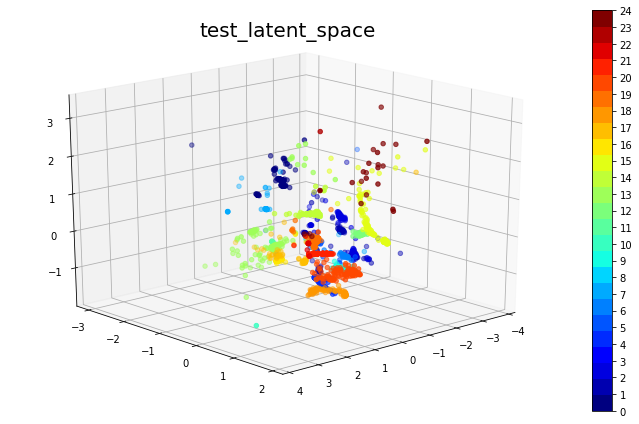

In [15]:
y_train = y_train.reshape((y_train.shape[0]))
y_test = y_test.reshape((y_test.shape[0]))

# Test Scatter Ploting, first run should set save predict to True
encoded_imgs, _, _ = encoder.predict(x_test, batch_size=hp_batch_size)
if save_predict:
    print("Saving test predict...", end='')
    y_test = y_test.reshape((y_test.shape[0],1))
    sav = np.column_stack((y_test, encoded_imgs))
    np.savetxt(iot_data_dir + "test_predict.csv", sav, delimiter=",")
    print("  Done.")

print("Reading test data...", end='')
test_img = np.loadtxt(iot_data_dir + "test_predict.csv", delimiter=",")
test_label = test_img[:,0]
test_img = test_img[:,1:]
print("  Success.")
plt_scatter(test_img,test_label, azim=48, elev=20, title="test_latent_space")

Saving train predict...  Done.
Reading train data...  Success.


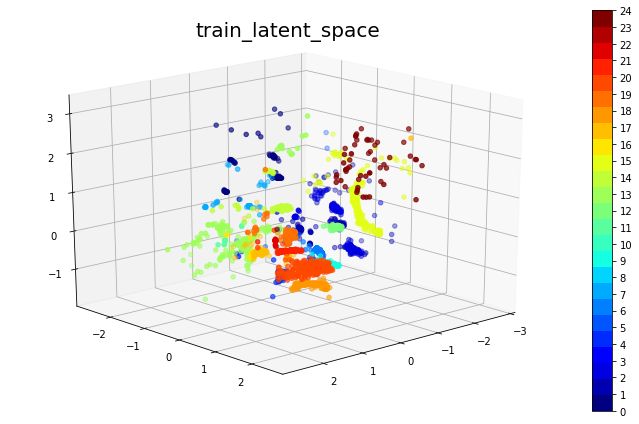

In [16]:
# Train Scatter Ploting, first run should set save predict to True
encoded_imgs, _, _ = encoder.predict(x_train, batch_size=hp_batch_size)
if save_predict:
    print("Saving train predict...", end='')
    y_train = y_train.reshape((y_train.shape[0],1))
    sav = np.column_stack((y_train, encoded_imgs))
    np.savetxt(iot_data_dir + "train_predict.csv", sav, delimiter=",")
    print("  Done.")

print("Reading train data...", end='')
train_img = np.loadtxt(iot_data_dir + "train_predict.csv", delimiter=",")
train_label = train_img[:,0]
train_img = train_img[:,1:]
print("  Success.")
plt_scatter(train_img,train_label, azim=48, elev=20, title="train_latent_space")

In [17]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, title=None, cmap=plt.cm.Blues, save=False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    
    device_black_list = [3, 10, 23, 8]
    delete_list = []
    
    for i in range(0, y_true.shape[0]):
        if int(y_true[i]) in device_black_list:
            delete_list.append(i)
    y_true = np.delete(y_true, delete_list)
    y_pred = np.delete(y_pred, delete_list)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     print(cm.shape)
#     print(y_true.shape)
#     print(y_pred.shape)
    # Only use the labels that appear in the data
    uniqueLabel = np.unique(np.row_stack((y_true,y_pred)))
    new_class = []
    for i in range(0, uniqueLabel.shape[0]):
        if uniqueLabel[i] not in device_black_list:
            new_class.append(classes[int(uniqueLabel[i])])
    classes = new_class
    del new_class
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 18)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.figure.colorbar(im,fraction=0.046, pad=0.04, aspect=20)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_ylabel('True label',fontsize=18)
    ax.set_xlabel('Predicted label',fontsize=18)
    ax.set_title(title, fontsize=20)
#     ttl = ax.title
#     ttl.set_position([.5, 1.02]) #标题距离
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save:
        fig.savefig(title)
    return ax

In [18]:
# K-Means Model
print("Training K-Means model...",end='')
model = KMeans(n_clusters=25, max_iter=512, n_init=128, n_jobs=16, random_state=0).fit(train_img)
print("Done.")

model_label = model.labels_
label_map = np.zeros((25,))

match_cnt = np.zeros((25,25))
for i in range(0, train_label.shape[0]):
    match_cnt[int(train_label[i])][model_label[i]] += 1

label_map = match_cnt.argmax(axis=0)
print("Label map:")
print(label_map)
del match_cnt

Training K-Means model...Done.
Label map:
[ 2 20 16  0 12  5 14 18  7  2 15 13 15  4 17 18  1  9 21 17 24 11  1  1
  0]


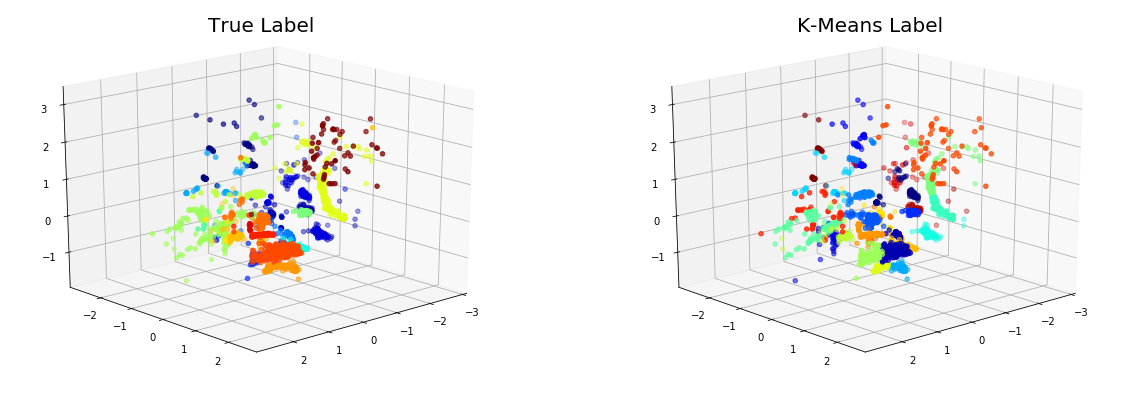

In [19]:
# Comparison of true label with k-means label
ticks = np.arange(0,25)
fig = plt.figure(figsize=(20,7))

ax1 = fig.add_subplot(121, projection='3d')
ax1.view_init(azim=48,elev=20)
ax1.set_title("True Label",fontsize=20)
p1 = ax1.scatter(train_img[:, 0], train_img[:, 1], train_img[:, 2],
               c=train_label, cmap=plt.cm.get_cmap('jet', 25))
# fig.colorbar(p1, ticks=ticks,fraction=0.046, pad=0.04, aspect=20)

ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(azim=48,elev=20)
ax2.set_title("K-Means Label",fontsize=20)
p2 = ax2.scatter(train_img[:, 0], train_img[:, 1], train_img[:, 2],
               c=model_label, cmap=plt.cm.get_cmap('jet', 25))
# fig.colorbar(p2, ticks=ticks,fraction=0.046, pad=0.04, aspect=20)

plt.show()

del ticks
del ax1
del p1
del ax2
del p2

In [20]:
# Total Accuracy Calculation
"""
NOTICE: SINCE WE DID NOT CONTROL THE INITIALIZATION OF THE NEURAL NETWORK
        IT IS POSSIBLE FOR THE ACCURACY TO BE DIFFERENT FROM THE PAPER
        BUT THE RESULT SHOULD VIBRATE NEAR 85%
"""

pred = model.predict(test_img)

acc = 0
acc_cls = np.zeros((25,2))
for i in range(0, test_label.shape[0]):
    pred[i] = label_map[pred[i]]
    acc_cls[int(test_label[i])][0] += 1
    if test_label[i] == pred[i]:
        acc += 1
        acc_cls[int(test_label[i])][1] += 1
acc = acc / test_label.shape[0]
print("Total acc: %.3f"%(acc*100) + " %")

Total acc: 84.953 %


Normalized confusion matrix


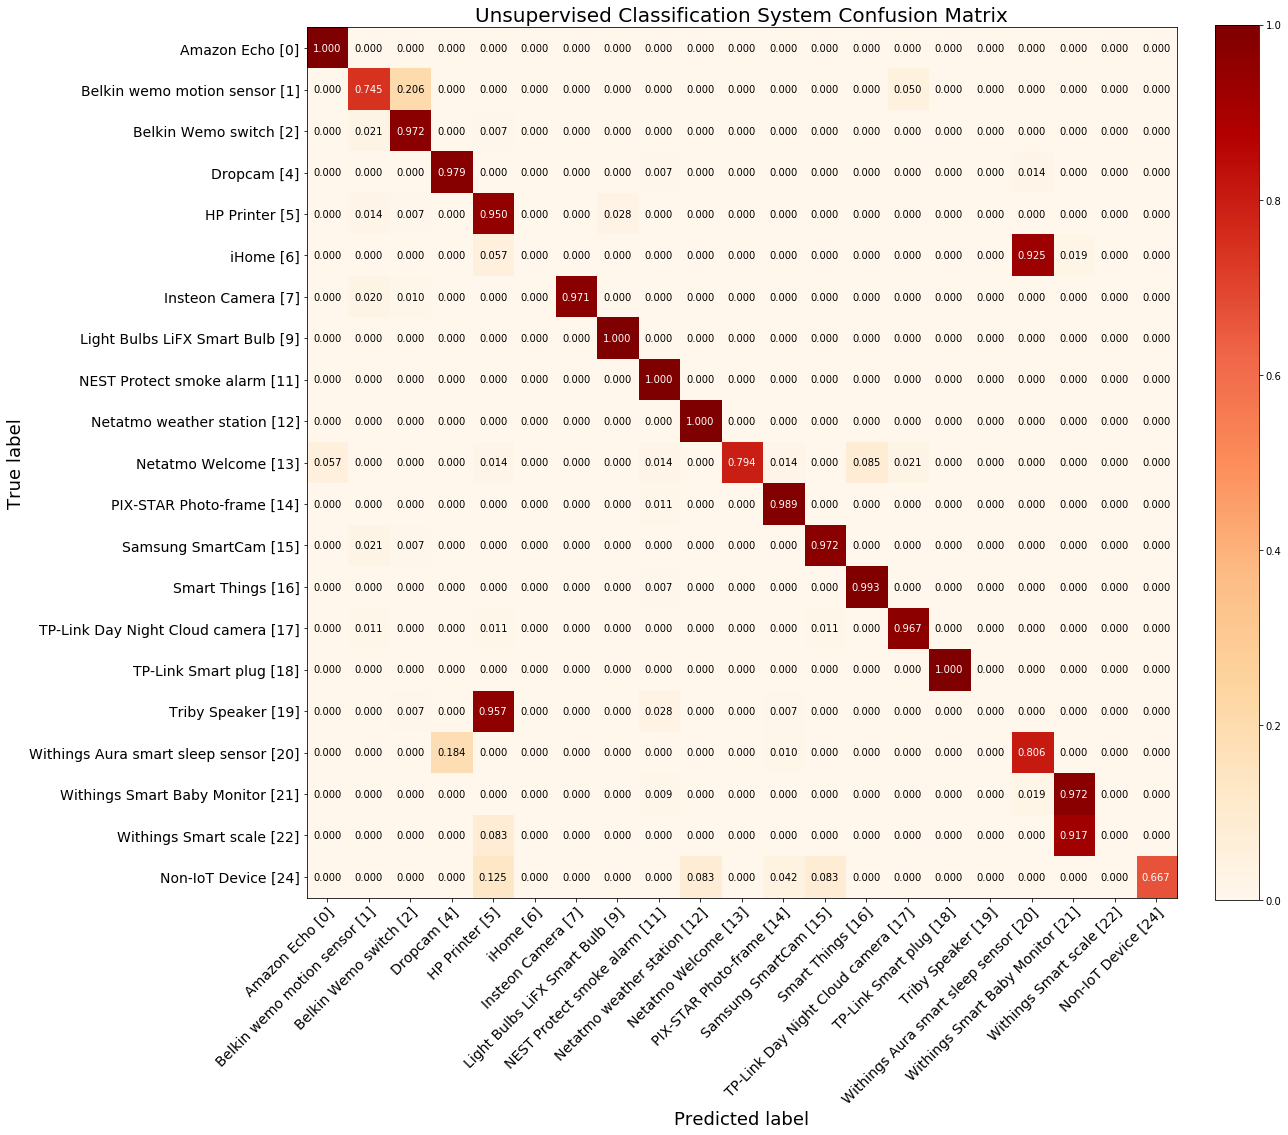

In [21]:
plot_confusion_matrix(test_label, pred, device_list, title="Unsupervised Classification System Confusion Matrix", cmap=plt.cm.OrRd)

Confusion matrix, without normalization


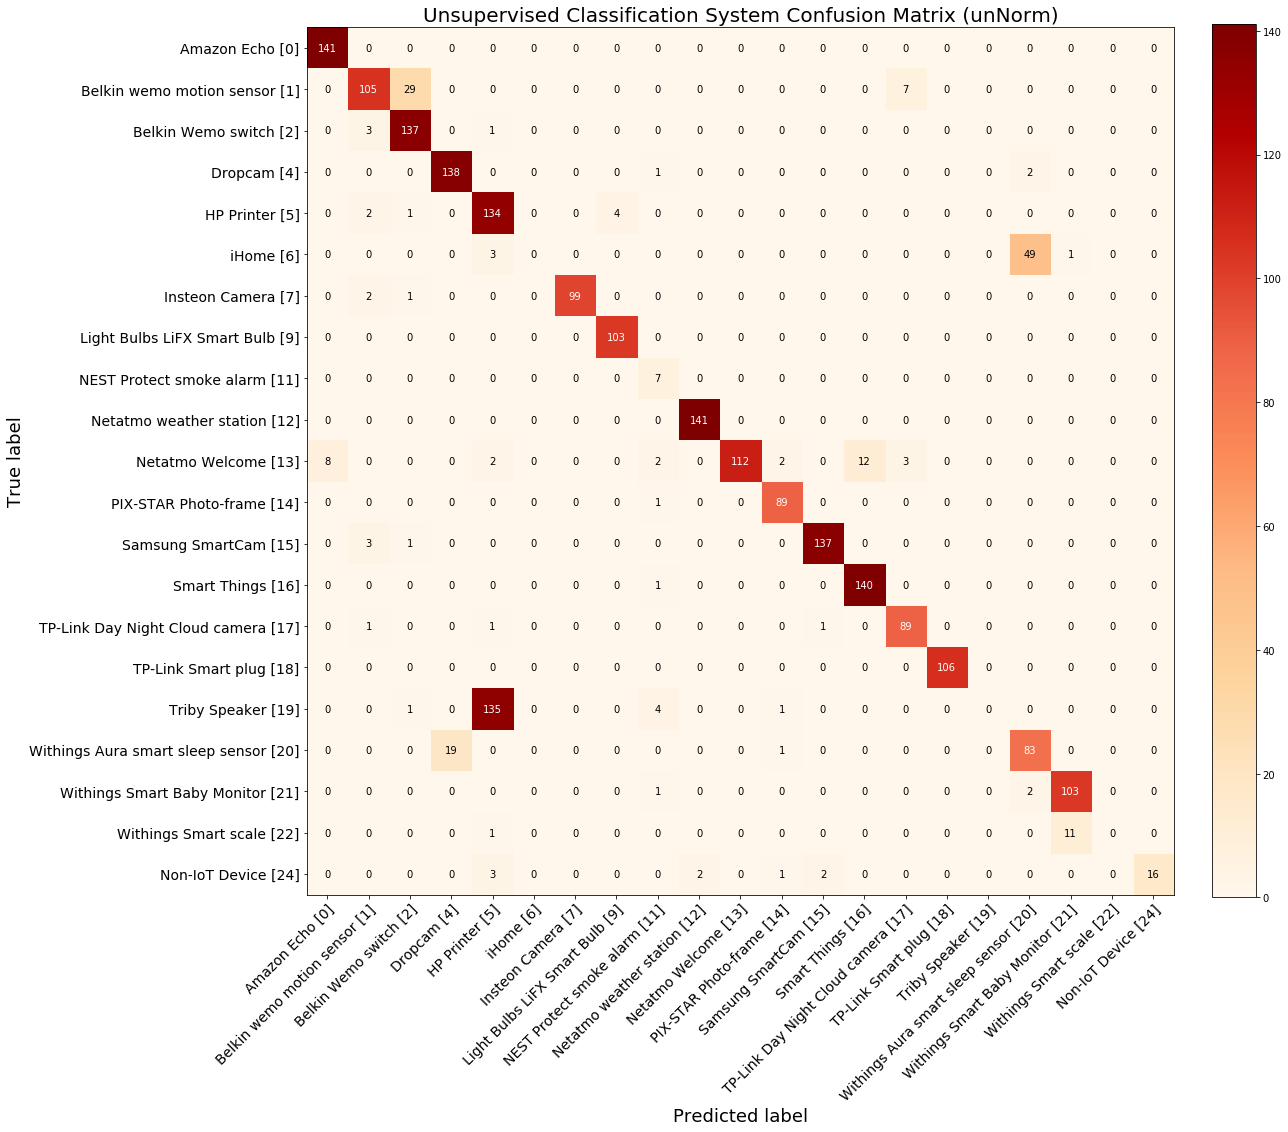

In [22]:
plot_confusion_matrix(test_label, pred, device_list, title="Unsupervised Classification System Confusion Matrix (unNorm)", cmap=plt.cm.OrRd, normalize=False)

In [23]:
# Demo of model with acc 86.7%
print("Reading best test data...", end='')
test_img = np.loadtxt(iot_data_dir + "test_predict_acc86.csv", delimiter=",")
test_label = test_img[:,0]
test_img = test_img[:,1:]
print(" Success.")

print("Reading best train data...", end='')
train_img = np.loadtxt(iot_data_dir + "train_predict_acc86.csv", delimiter=",")
train_label = train_img[:,0]
train_img = train_img[:,1:]
print(" Success.")

Reading best test data... Success.
Reading best train data... Success.


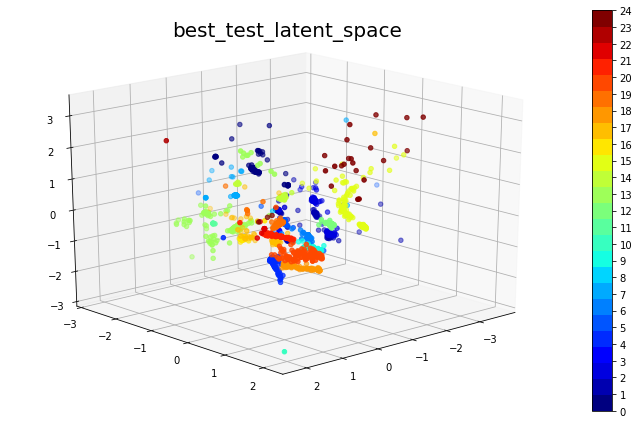

In [24]:
plt_scatter(test_img,test_label, azim=48, elev=20, title="best_test_latent_space", save=True)

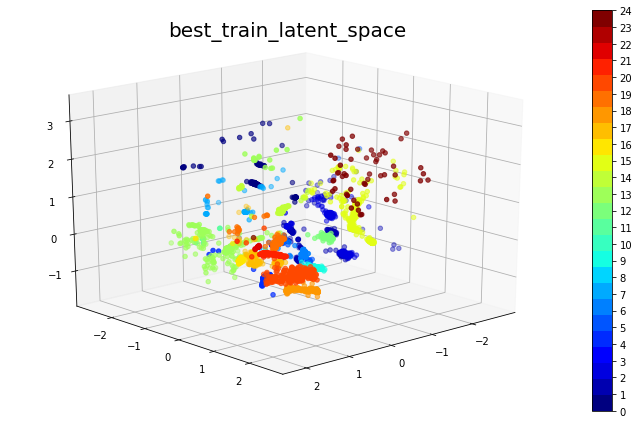

In [25]:
plt_scatter(train_img,train_label, azim=48, elev=20, title="best_train_latent_space", save=True)

In [26]:
# K-Means Model
print("Training K-Means model for best latent space...",end='')
model = KMeans(n_clusters=25, max_iter=512, n_init=128, n_jobs=16, random_state=0).fit(train_img)
print("Done.")

model_label = model.labels_
label_map = np.zeros((25,))

match_cnt = np.zeros((25,25))
for i in range(0, train_label.shape[0]):
    match_cnt[int(train_label[i])][model_label[i]] += 1

label_map = match_cnt.argmax(axis=0)
print("Label map:")
print(label_map)
del match_cnt

Training K-Means model for best latent space...Done.
Label map:
[11 12 16  2 19 20  0 14 18 15  1 17  7  1 21 24 17  4  9 13 18  1  7 15
  6]


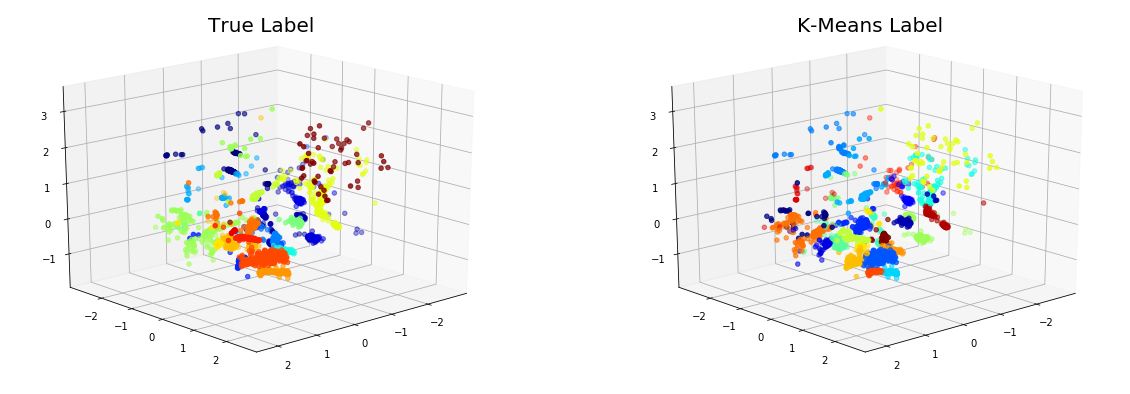

In [27]:
# Comparison of true label with k-means label
ticks = np.arange(0,25)
fig = plt.figure(figsize=(20,7))

ax1 = fig.add_subplot(121, projection='3d')
ax1.view_init(azim=48,elev=20)
ax1.set_title("True Label",fontsize=20)
p1 = ax1.scatter(train_img[:, 0], train_img[:, 1], train_img[:, 2],
               c=train_label, cmap=plt.cm.get_cmap('jet', 25))
# fig.colorbar(p1, ticks=ticks,fraction=0.046, pad=0.04, aspect=20)

ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(azim=48,elev=20)
ax2.set_title("K-Means Label",fontsize=20)
p2 = ax2.scatter(train_img[:, 0], train_img[:, 1], train_img[:, 2],
               c=model_label, cmap=plt.cm.get_cmap('jet', 25))
# fig.colorbar(p2, ticks=ticks,fraction=0.046, pad=0.04, aspect=20)

plt.show()

del ticks
del ax1
del p1
del ax2
del p2

In [28]:
# Best Total Accuracy Calculation
pred = model.predict(test_img)

acc = 0
acc_cls = np.zeros((25,2))
for i in range(0, test_label.shape[0]):
    pred[i] = label_map[pred[i]]
    acc_cls[int(test_label[i])][0] += 1
    if test_label[i] == pred[i]:
        acc += 1
        acc_cls[int(test_label[i])][1] += 1
acc = acc / test_label.shape[0]
print("Total acc: %.3f"%(acc*100) + " %")

Total acc: 86.715 %


Normalized confusion matrix


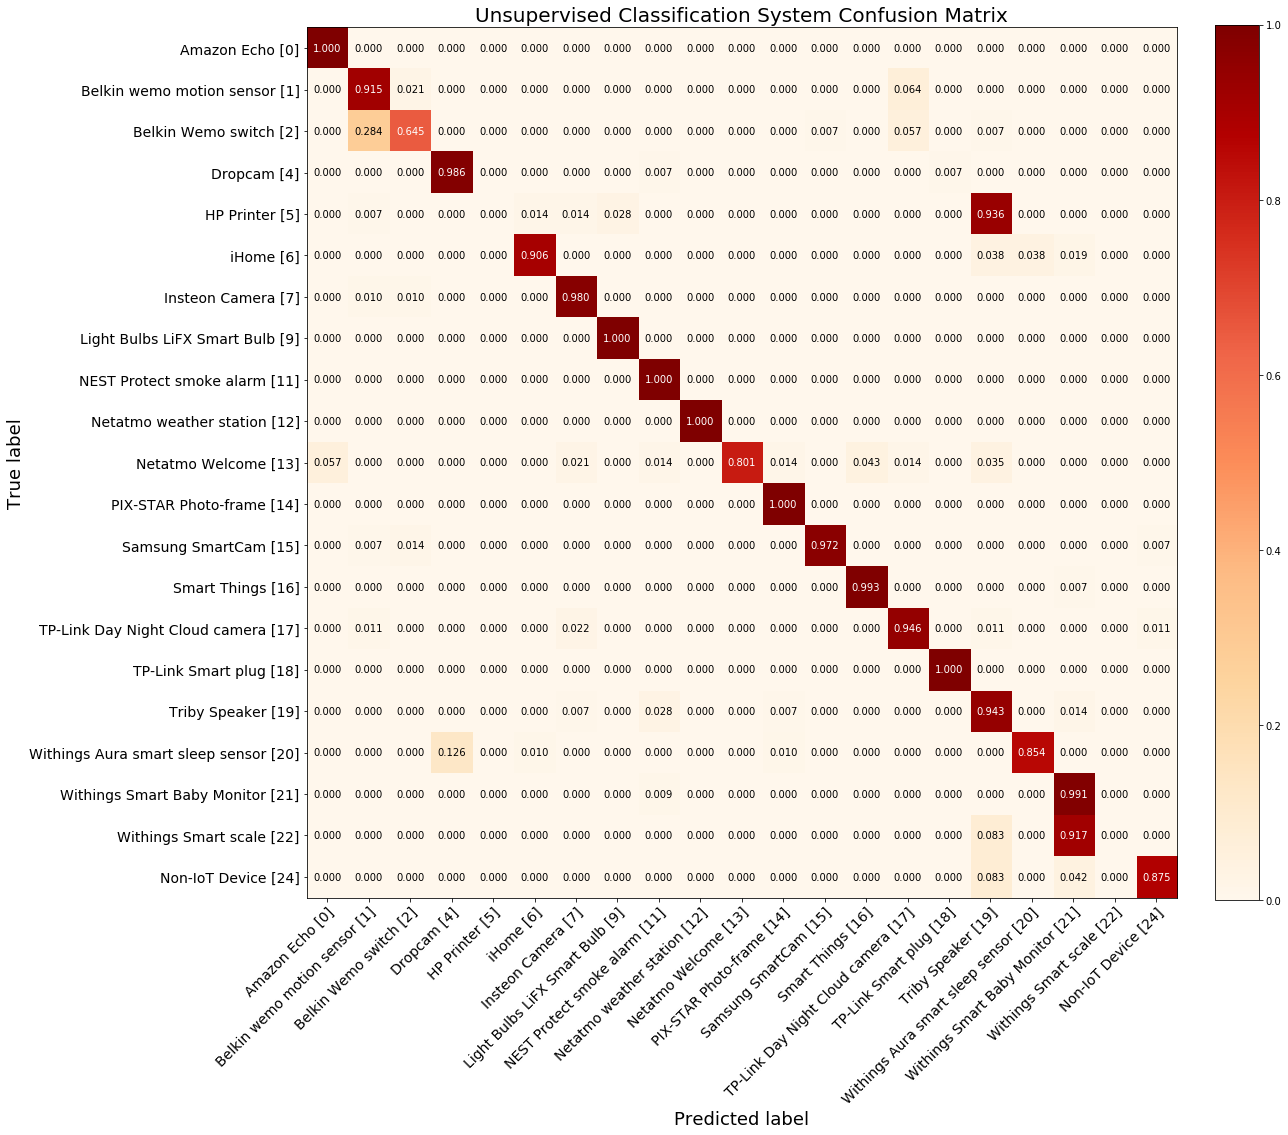

In [29]:
plot_confusion_matrix(test_label, pred, device_list, title="Unsupervised Classification System Confusion Matrix", cmap=plt.cm.OrRd, save=True)

Confusion matrix, without normalization


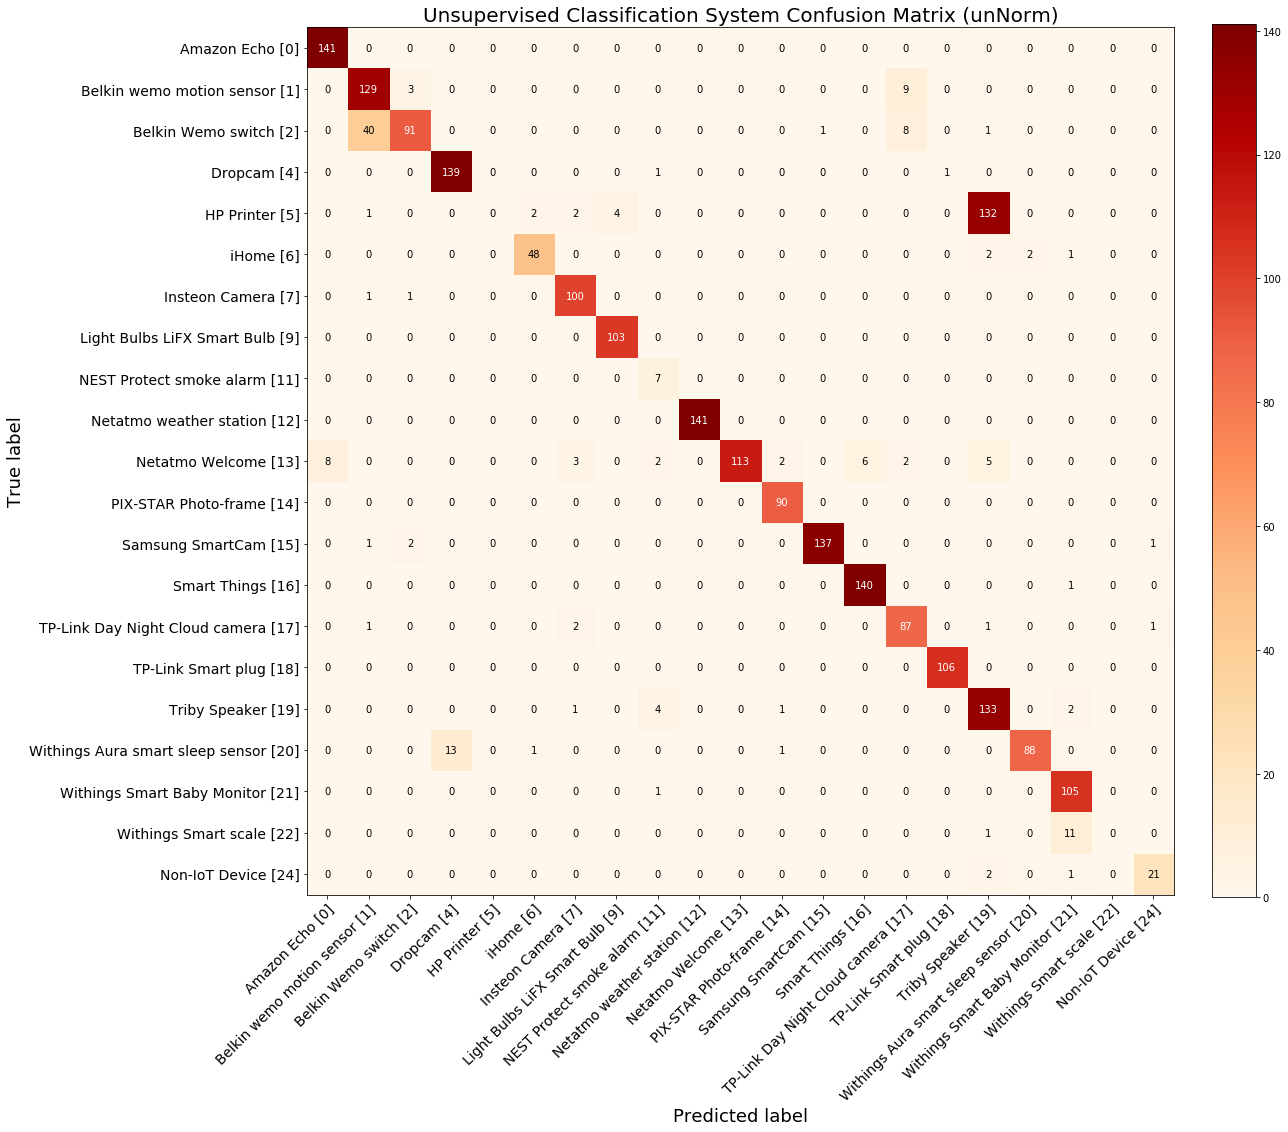

In [30]:
plot_confusion_matrix(test_label, pred, device_list, title="Unsupervised Classification System Confusion Matrix (unNorm)", cmap=plt.cm.OrRd, normalize=False, save=True)